# Hueristic strategy movie

In [1]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts


In [2]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
#pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)

In [3]:
from lib.lib import get_trajs,get_pt_plus

In [4]:
#check these are consistent with dyn_prog_model.npy
para=dict()
para['T']=15
para['T_ITI']=8#para['T']/2=7.5 in primate experiments set to 8 so that all trial durations are integers
para['p']=1/2
para['tp']=0
alp_slow=1/4
alp_fast=3/4
alpvec=np.asarray([alp_slow,alp_fast])

In [5]:
df_traj=get_trajs()
df_traj.head()
def dummy(Nt_seq):
    return np.array([(get_pt_plus(t,Nt) if Nt>=0 else 1-get_pt_plus(t,Nt)) for t,Nt in enumerate(Nt_seq)])
df_traj['p_suc_seq']=df_traj.Nt.apply(lambda x: dummy(x))
# df_traj['evidence']=df_traj.Pt_plus.apply(lambda x: np.log(x/(1-x)))
# df_traj['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)

In [6]:
def filter_step(filtered_value,input_sample,inter_event_interval,filter_factor): #filter factor is 1/(1+filter_timescale)
    tmp=np.power(1-filter_factor,inter_event_interval)
    return tmp*filtered_value+(1-tmp)*input_sample 

def get_trial_duration(t,alpha):
    return t+(1-alpha)*(para['T']-t)+para['T_ITI']

still frame

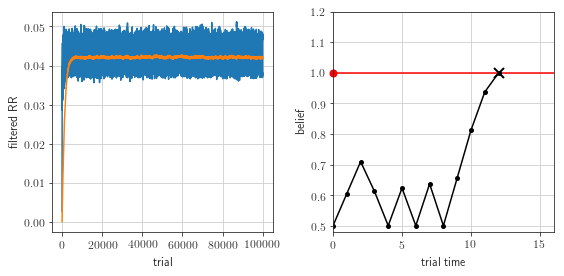

In [36]:
fig,ax=pl.subplots(1,2,figsize=(8,4))
rho_long=0
rho_short=0
T_short=0

trial_time_vec=np.arange(para['T']+2)
urgency=rho_long*trial_time_vec+(rho_short-rho_long)*T_short

ax[1].plot(trial_time_vec,1-urgency,'r-')
ax[1].plot([0],[1-urgency[0]],'ro',clip_on=False)
ax[1].set_ylim(0.48,1.2)
ax[1].set_xlim(0,para['T']+1)

sample_trial=df_traj.sample().iloc[0]
t_decision=int(np.where(sample_trial.p_suc_seq>=1-urgency[:-1])[0][0])
ax[1].plot(range(t_decision+1),sample_trial.p_suc_seq[:t_decision+1],'k.-')
# ax[0,3].plot(range(t_decision+1),sample_trial.p_suc_seq[:t_decision+1],'ko-')
ax[1].plot([t_decision],[sample_trial.p_suc_seq[t_decision]],'kx',ms=10,clip_on=False)
ax[1].set_ylabel('belief')
ax[1].set_xlabel('trial time')

ax[0].plot(rho_context_store)
ax[0].plot(rho_long_store)
ax[0].set_xlabel('trial')
ax[0].set_ylabel('filtered RR')
fig.tight_layout()

In [7]:
from IPython import display

In [17]:
import matplotlib as mpl

In [8]:
import subprocess

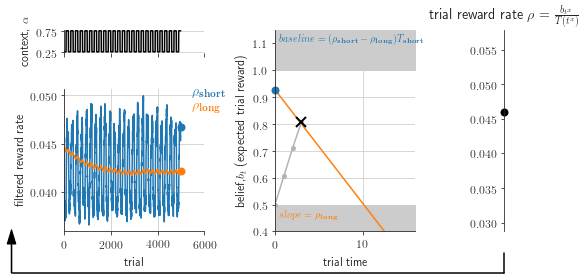

477.7022485733032


In [23]:
max_trial_iter=int(5e3)
trials_per_context=100
context_seq=np.tile(np.concatenate((np.zeros(trials_per_context,dtype=int),np.ones(trials_per_context,dtype=int))),int(max_trial_iter/trials_per_context/2))
nPostIntervalvec=[150,50]
average_trial_duration=get_trial_duration(6,0.5)

tau_context=average_trial_duration*20
tau_long=10*trials_per_context*average_trial_duration
beta_long=1/(1+tau_long)
beta_context=1/(1+tau_context)

#storage
rho_long_store=np.zeros(max_trial_iter)
rho_context_store=np.zeros(max_trial_iter)
T_context_store=np.zeros(max_trial_iter)
t_decision_store=np.zeros(max_trial_iter)
Nt_at_tdec_store=np.zeros(max_trial_iter)

#initialize
rho_long=0
rho_context=0
T_context=0

trial_time_vec=np.arange(para['T']+2)
st=time.time()
df_data_sim=[]
itt=-1
for it in range(max_trial_iter):
   

    sample_trial=df_traj.sample().iloc[0]

    urgency=rho_long*trial_time_vec+(rho_context-rho_long)*T_context
    
    t_decision=int(np.where(sample_trial.p_suc_seq>=1-urgency[:-1])[0][0])
    Nt_at_tdec=sample_trial.Nt[t_decision]
    if np.sign(Nt_at_tdec)!=0:
        nChoiceMade=np.sign(Nt_at_tdec)
    else:
        nChoiceMade=np.random.choice((-1,1))
    duration=get_trial_duration(t_decision,alpvec[context_seq[it]])
    
    trial_RR=sample_trial.p_suc_seq[t_decision]/duration
    if it==0:
        rho_long=trial_RR
        rho_context=trial_RR
        T_context=duration
    rho_long =   filter_step(rho_long   , trial_RR, duration, beta_long)
    rho_context =filter_step(rho_context, trial_RR, duration, beta_context)
    T_context=   filter_step(T_context  , duration, duration, beta_context)

    sample_trial=df_traj.sample().iloc[0]
    t_decision=int(np.where(sample_trial.p_suc_seq>=1-urgency[:-1])[0][0])
        
    rho_long_store[it]=rho_long
    rho_context_store[it]=rho_context
    T_context_store[it]=T_context
    t_decision_store[it]=t_decision
    Nt_at_tdec_store[it]=Nt_at_tdec
    
    if it%10==0:
        itt+=1
        fig=pl.figure(figsize=(8,4))
        gs = fig.add_gridspec(4, 5)
        ax=[0,0,0,0]
        ax[1]=fig.add_subplot(gs[:,2:4])
        ax[0]=fig.add_subplot(gs[1:,:2])
        ax[2]=fig.add_subplot(gs[0,:2])
        ax[3]=fig.add_subplot(gs[:,4])
        ax[2].plot(range(it),alpvec[context_seq[:it]],'k-')
        ax[3].plot([0],[trial_RR],'ko')
        ax[3].set_xticks([])
        ax[3].grid(False)
        ax[3].set_title(r'trial reward rate $\rho=\frac{b_{t^x}}{T(t^x)}$')
        ax[3].set_xlim(-0.1,0.1)
        ax[3].spines['right'].set_visible(False)
        ax[3].spines['top'].set_visible(False)
        ax[3].spines['bottom'].set_visible(False)
        ax[3].spines['left'].set_position('center')
        ax[1].plot(trial_time_vec,1-urgency,'-',color='C1')
        ax[1].plot([0],[1-urgency[0]],'o',color='C0',clip_on=False)
        ax[1].plot(range(t_decision+1),sample_trial.p_suc_seq[:t_decision+1],'.-',color=[0.7]*3)
        ax[1].plot([t_decision],[sample_trial.p_suc_seq[t_decision]],'kx',ms=10,clip_on=False)
        ax[0].plot(rho_context_store[:it+1],color='C0')
        ax[0].plot([it],[rho_context_store[it]],'o',color='C0')
        ax[0].plot(rho_long_store[:it+1],color='C1')
        ax[0].plot([it],[rho_long_store[it]],'o',color='C1')

        ax[1].set_ylabel(r'belief,$b_t$ (expected trial reward)')
        ax[1].set_xlabel('trial time')
        ax[1].set_ylim(0.4,1.15)
        ax[1].set_xlim(0,para['T']+1)
        ax[0].set_xlabel('trial')
        ax[0].set_ylabel('filtered reward rate')
        
        ax[1].text(0.5,1.1,r'\textbf{$baseline=(\rho_\textrm{short}-\rho_\textrm{long})T_\textrm{short}$}',color='C0',fontsize=10)
        ax[1].text(0.5,0.45,r'\textbf{$slope=\rho_\textrm{long}$}',color='C1',fontsize=10)
        ax[0].text(it*(1.1),ax[0].get_ylim()[0]+0.95*np.diff(ax[0].get_ylim()),r'\textbf{$\rho_\textrm{short}$}',color='C0',fontsize=14)
        ax[0].text(it*(1.1),ax[0].get_ylim()[0]+0.85*np.diff(ax[0].get_ylim()),r'\textbf{$\rho_\textrm{long}$}',color='C1',fontsize=14)
        ax[0].set_xlim(0,it*(1.2))
        ax[2].set_xlim(0,it*(1.2))
        ax[2].set_ylabel(r'context, $\alpha$')
        fig.tight_layout()
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
        ax[2].spines['right'].set_visible(False)
        ax[2].spines['top'].set_visible(False)
        ax[2].spines['bottom'].set_visible(False)
        ax[2].set_yticks((1/4,3/4))
        ax[2].set_xticklabels([])
        ax[1].fill_between([0,16],[1,1],[1.15,1.15],color=[0.8]*3)
        ax[1].fill_between([0,16],[0.4,0.4],[0.5,0.5],color=[0.8]*3)
        ylimits=np.asarray(ax[0].get_ylim())
        center_y=np.mean(ylimits)
        ax[3].set_ylim(2*(ylimits-center_y)+center_y)
        
        height=0.03
        xpos=0.885
        xmin=0.03
        l1=mpl.lines.Line2D([xpos,xpos],[0.1,height],transform=fig.transFigure,figure=fig,color='k')
        l2=mpl.lines.Line2D([xmin,xpos],[height,height],transform=fig.transFigure,figure=fig,color='k')
        l3=mpl.patches.FancyArrow(xmin,height,0,0.1,transform=fig.transFigure,figure=fig,color='k',head_width=0.015,head_length=0.05)
        fig.lines.extend([l1,l2,l3])
        
        display.clear_output(wait=True)
        display.display(fig)
        pl.close()
        fig.savefig('trial_ARRL_'+str(itt)+'.png', transparent=True,bbox_inches='tight',dpi=300)
    
df_data_sim.append({'seq':sample_trial.seq, 
                    'nChoiceMade':nChoiceMade,
                    'tDecision':t_decision,
                    'nPostInterval':nPostIntervalvec[context_seq[it]]
#                         'Nt':sample_trial.Nt,'p_suc_seq':sample_trial.p_suc_seq,'duration':duration,'RR':trial_RR,},
                   })
df_data_sim=pd.DataFrame(df_data_sim)
print(time.time()-st)
pl.show()


In [33]:
import subprocess

In [25]:
cd notebooks

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/notebooks


In [27]:
subprocess.call(['ffmpeg','-framerate','8','-i','trial_ARRL_%01d.png','-r','30','-vf','pad=ceil(iw/2)*2:ceil(ih/2)*2','-pix_fmt','yuv420p','test.mp4'])

0